# Peer-graded Assignment: Прогнозирование большого количества рядов

In [1]:
import pickle
from scipy import stats
import pandas as pd
import numpy as np
import calendar
from time import mktime
from sklearn.linear_model import LinearRegression as LR
import statsmodels.api as sm
import matplotlib.pyplot as plt
import os
import warnings
import itertools
%pylab inline

/home/feshch/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


## Загрузка данных за полгода с февраля по июнь 2016

In [5]:
def data_for_time_interval_and_region(first_year, first_month, last_year, last_month, data_dir = '../Data_aggr/'):
    data = pd.DataFrame()
    y = first_year
    m = first_month
    while [2016, 6]>=[y, m]:
        if [last_year, last_month]>=[y, m]:
            data_ = pd.read_csv(data_dir+str(y)+'-'+str(m)+'.csv', index_col='Unnamed: 0')
            data = pd.concat([data, data_])
        if m == 12:
            m = 1
            y += 1
        else:
            m += 1
    return data

In [6]:
data_tmp = data_for_time_interval_and_region(2016, 2, 2016, 6)
data_tmp.head()

/home/feshch/anaconda3/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,pickup_hour,region,cnt
0,2016-02-01 00:00:00,1,0
1,2016-02-01 00:00:00,2,0
2,2016-02-01 00:00:00,3,0
3,2016-02-01 00:00:00,4,0
4,2016-02-01 00:00:00,5,0


In [7]:
ind = pd.to_datetime(sorted(data_tmp.pickup_hour.value_counts().index))
cols = sorted(data_tmp.region.value_counts().index)

data = pd.DataFrame(index=ind, columns=cols, 
                    data = data_tmp.cnt.values.reshape((len(ind), len(cols))))
data.head()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-02-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 01:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 02:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01 04:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Взглянем на данные по количеству поездок в логарифмическом масштабе:

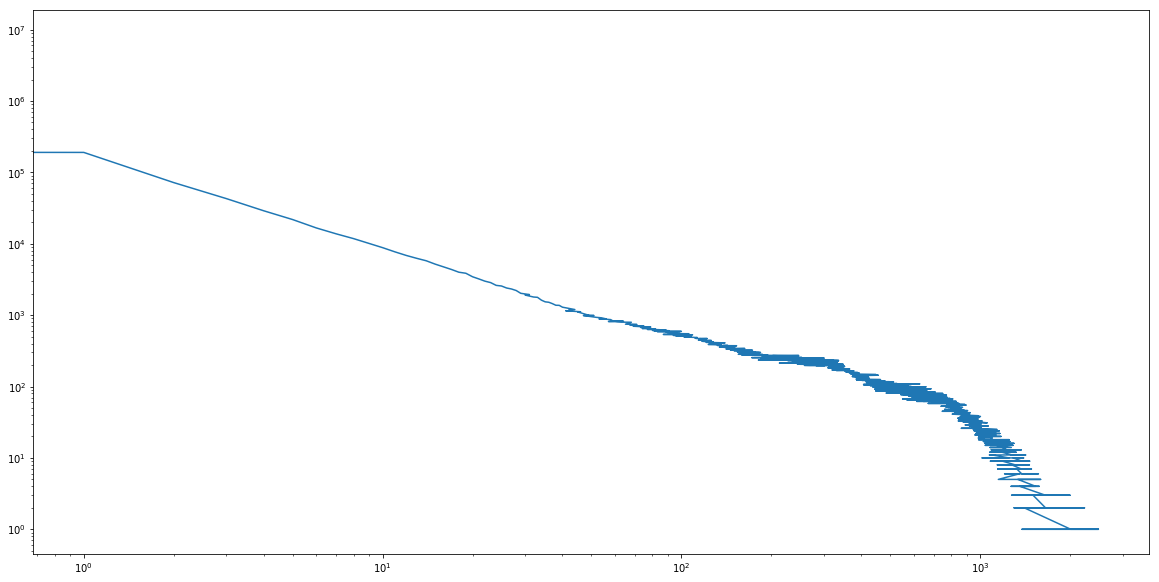

In [5]:
plt.figure(figsize=(20,10))
plt.yscale('log')
plt.xscale('log')
plt.plot(data_tmp.cnt.value_counts())

## Отделяем данные для обучения

In [8]:
test_datetimes_cnt = 720
train = data.head(len(ind)-test_datetimes_cnt)
test = data.tail(test_datetimes_cnt)
train.tail()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
2016-05-31 19:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 20:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 21:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 22:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-31 23:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
train.describe()

,1,2,3,4,5,6,7,8,9,10,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,2500
count,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.000000,...,2904.000000,2904.000000,2904.000000,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0,2904.0
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000344,...,0.000689,0.002066,0.000344,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018557,...,0.026239,0.052455,0.018557,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,...,1.000000,2.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
train.describe().T['max'].value_counts().sort_index()

0.0       814
1.0       742
2.0       299
3.0       185
4.0       122
5.0        80
6.0        40
7.0        18
8.0        11
9.0        12
10.0        6
11.0        6
12.0        5
13.0        6
14.0        5
15.0        2
16.0        2
18.0        4
19.0        2
21.0        7
22.0        5
23.0        2
24.0        1
25.0        4
26.0        2
27.0        1
28.0        2
30.0        1
31.0        2
32.0        1
         ... 
516.0       1
525.0       1
626.0       2
629.0       1
681.0       1
691.0       1
708.0       1
810.0       1
892.0       1
898.0       1
902.0       1
948.0       1
1055.0      1
1059.0      1
1109.0      1
1154.0      1
1217.0      1
1262.0      1
1297.0      1
1335.0      1
1401.0      1
1473.0      1
1521.0      1
1538.0      1
1568.0      1
1596.0      1
1683.0      1
1728.0      1
1949.0      1
2485.0      1
Name: max, Length: 127, dtype: int64

## Думаю, если из области катаются реже, чем раз в неделю, говорить о недельной сезонности не приходится, а даже если катаются больше, характер поездок может быть случайным, либо сильно обусловленным аномалиями, а это, как было экспериментально выяснено, мешает при кластеризации. Посмотрим, сколько минимум рядов можно отбрасывать в кластер, где мы ничего не сможем предсказать.

In [6]:
avg = train.describe().T['mean'].value_counts().sort_index()
sum(avg[avg.index < 1./168].values) # Отсюда катаются не чаще раза в день

1740

In [24]:
sum(avg[avg.index < 1./24].values) # Отсюда катаются не чаще раза в день

2094

In [25]:
sum(avg[avg.index < 1.].values) # Отсюда катаются не чаще раза в час

2338

In [7]:
threshold = 1.
avg = train.describe().T['mean']
significant = train[list(np.where((avg > threshold).values)[0])]
significant.head(24)

,1074,1075,1076,1077,1121,1122,1124,1125,1126,1127,...,2019,2020,2021,2022,2067,2068,2069,2117,2118,2167
2016-02-01 00:00:00,0,19,26,5,0,2,0,15,76,92,...,4,2,0,0,0,80,15,0,184,0
2016-02-01 01:00:00,0,6,17,5,0,0,0,5,29,53,...,1,0,0,1,0,8,1,0,27,0
2016-02-01 02:00:00,0,5,5,1,0,0,0,6,21,31,...,0,0,0,0,0,13,0,0,11,0
2016-02-01 03:00:00,0,4,0,0,0,0,0,3,9,36,...,0,0,0,0,0,6,0,0,2,0
2016-02-01 04:00:00,0,4,4,2,0,0,0,10,15,46,...,0,0,0,0,0,0,0,0,31,0
2016-02-01 05:00:00,0,12,32,15,0,0,0,13,37,51,...,3,0,1,1,0,39,17,0,114,0
2016-02-01 06:00:00,0,28,63,81,0,7,0,47,100,150,...,3,0,3,4,0,105,12,0,189,0
2016-02-01 07:00:00,0,32,128,153,0,9,0,56,131,272,...,1,0,1,3,0,64,8,0,136,0
2016-02-01 08:00:00,0,91,181,205,0,12,0,105,225,335,...,1,0,2,1,0,29,3,0,51,0
2016-02-01 09:00:00,0,54,191,129,0,7,0,77,199,260,...,1,0,2,1,0,33,7,0,46,0


## Не уверен, что оставить только регионы, откуда катаются больше раза в час, поможет. Видно, что ещё есть места, откуда мало катаются, и поездки набираются во время аномалий.

In [8]:
threshold = 5.
significant = train[list(np.where((avg > threshold).values)[0])]
significant.head(24)

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1579,1683,1732,1733,1782,2067,2068,2117,2118,2167
2016-02-01 00:00:00,0,19,26,0,15,76,92,152,217,267,...,0,1,2,5,1,0,80,0,184,0
2016-02-01 01:00:00,0,6,17,0,5,29,53,104,116,182,...,0,1,0,3,0,0,8,0,27,0
2016-02-01 02:00:00,0,5,5,0,6,21,31,52,118,137,...,0,0,0,0,0,0,13,0,11,0
2016-02-01 03:00:00,0,4,0,0,3,9,36,32,76,106,...,0,0,1,0,0,0,6,0,2,0
2016-02-01 04:00:00,0,4,4,0,10,15,46,35,72,84,...,0,0,1,0,0,0,0,0,31,0
2016-02-01 05:00:00,0,12,32,0,13,37,51,51,85,52,...,0,0,5,0,3,0,39,0,114,0
2016-02-01 06:00:00,0,28,63,0,47,100,150,122,196,111,...,0,1,7,1,1,0,105,0,189,0
2016-02-01 07:00:00,0,32,128,0,56,131,272,223,395,197,...,1,2,3,7,1,0,64,0,136,0
2016-02-01 08:00:00,0,91,181,0,105,225,335,324,478,331,...,0,7,0,12,0,0,29,0,51,0
2016-02-01 09:00:00,0,54,191,0,77,199,260,242,454,339,...,0,10,0,8,0,0,33,0,46,0


## Оставлю threshold на уровне 5

# Стандартизация

In [9]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
significant = pd.DataFrame(index = train.index, columns = significant.columns, data = scaler.fit_transform(significant))
significant.head()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1579,1683,1732,1733,1782,2067,2068,2117,2118,2167
2016-02-01 00:00:00,-0.074503,-1.138672,-1.339667,-0.265233,-1.319506,-1.127935,-1.324091,-0.888980,-0.661964,-0.599569,...,-0.323358,-0.760817,0.677952,-0.083350,0.625316,-0.083624,-0.146458,-0.1198,0.619126,-0.063854
2016-02-01 01:00:00,-0.074503,-1.467009,-1.449361,-0.265233,-1.568010,-1.608119,-1.604433,-1.167515,-1.166498,-0.951117,...,-0.323358,-0.760817,-0.803442,-0.582932,-0.603316,-0.083624,-1.379946,-0.1198,-1.430518,-0.063854
2016-02-01 02:00:00,-0.074503,-1.492266,-1.595620,-0.265233,-1.543159,-1.689852,-1.762574,-1.469262,-1.156507,-1.137230,...,-0.323358,-1.031845,-0.803442,-1.332306,-0.603316,-0.083624,-1.294287,-0.1198,-1.639399,-0.063854
2016-02-01 03:00:00,-0.074503,-1.517522,-1.656561,-0.265233,-1.617710,-1.812452,-1.726633,-1.585319,-1.366313,-1.265442,...,-0.323358,-1.031845,-0.062745,-1.332306,-0.603316,-0.083624,-1.414210,-0.1198,-1.756895,-0.063854
2016-02-01 04:00:00,-0.074503,-1.517522,-1.607808,-0.265233,-1.443758,-1.751152,-1.654751,-1.567911,-1.386295,-1.356431,...,-0.323358,-1.031845,-0.062745,-1.332306,-0.603316,-0.083624,-1.517000,-0.1198,-1.378298,-0.063854


## По-прежнему много пустых или почти пустых ячеек, много пар (время, место), где не очень информативны нули, или места, откуда просто мало катаются, или ночное время суток, а также не стоит забывать про аномалии, где не слишком большое значение для предсказаний будет иметь отклонение от среднего. В этой ситуации для скорости и поднятия качества кластеризации можно было бы порезать размерность. Думаю, 168 - максимальная нужная размерность для исчерпывающего учёта региональной специфики недельной сезонности.

In [29]:
from sklearn.decomposition import PCA #Режу размерность
pca = PCA(n_components = 168)
pca.fit(significant.T)
X = pd.DataFrame(columns = significant.columns, data = pca.transform(significant.T).transpose())
X.head()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1579,1683,1732,1733,1782,2067,2068,2117,2118,2167
0,9.866455,-24.135297,-33.055217,6.569816,-21.223837,-19.693836,-5.707719,7.061988,20.384924,26.695207,...,9.901529,-19.782689,16.516096,-21.324736,14.767839,8.159167,-14.798142,8.464049,-12.037507,9.031623
1,10.243044,-18.109789,-5.741261,7.001506,-18.701188,-20.569326,-26.293603,-30.488884,-17.442864,-25.207741,...,11.375629,-7.094052,38.797983,-2.828110,29.262606,10.492563,-13.997714,8.133526,-9.384335,11.430927
2,23.683446,8.294525,3.982256,19.099490,-0.141809,-3.036114,-9.565353,-9.071114,-18.782534,-4.680633,...,21.551678,23.329313,17.054013,15.728566,21.913724,25.296410,18.687131,23.943040,17.802388,24.698703
3,-3.203285,3.979954,-3.483348,5.295155,2.942503,3.223399,-2.714587,0.288114,-6.636408,-11.267622,...,-4.212943,1.969698,-1.810133,4.807473,0.573463,-0.332196,23.188429,-0.302186,27.899563,2.429900
4,-7.013707,3.819587,1.918649,-2.226571,-5.849348,2.752659,-4.936528,-1.247476,-1.396725,7.492556,...,-7.277536,-5.808942,-2.640940,-5.476552,-4.433358,-7.007731,11.936532,-4.980099,8.358480,-3.715052


# Количество кластеров подбиралось эмпирически, проверялось соответствование следующим требованиям: 
## 1) Регионы, откуда катаются мало, в которых сложно что-либо предсказать, не должны попадать в разные кластеры, кластер у них, скорее всего, обоснован компонентами PCA, возникающими от праздников и аномалий, и не несут полезной предсказательной нагрузки при прогнозе меньше, чем на год. Подобная ситуация потребовала бы значительных затрат временных и вычислительных ресурсов.
## 2) Приветствуются визуально детектируемые различия в паттернах поведения графиков для разных кластеров, и сходства внутри одного кластера.
## 3) Размеры кластеров должны распределяться более-менее равномерно.

In [10]:
n_clusters = 3

# Кластеризация

In [30]:
from sklearn.cluster import KMeans #Кластеризую
kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X.T)
pd.Series(kmeans.labels_).value_counts() #Гляжу, сколько в каком кластере

1    43
2    31
0    24
dtype: int64

## Посмотрим на графики по кластерам

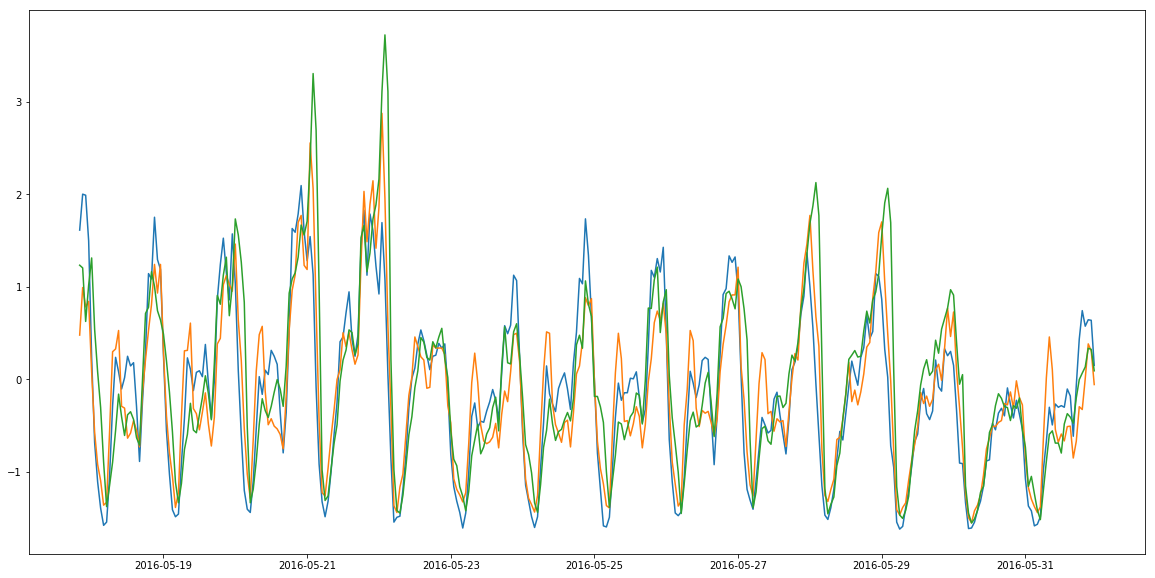

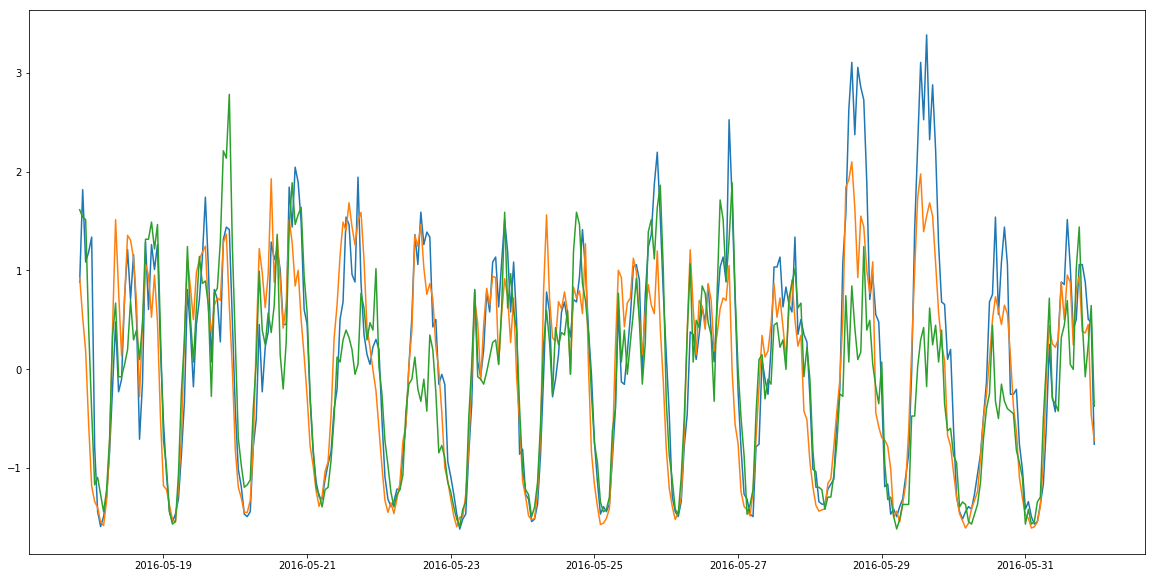

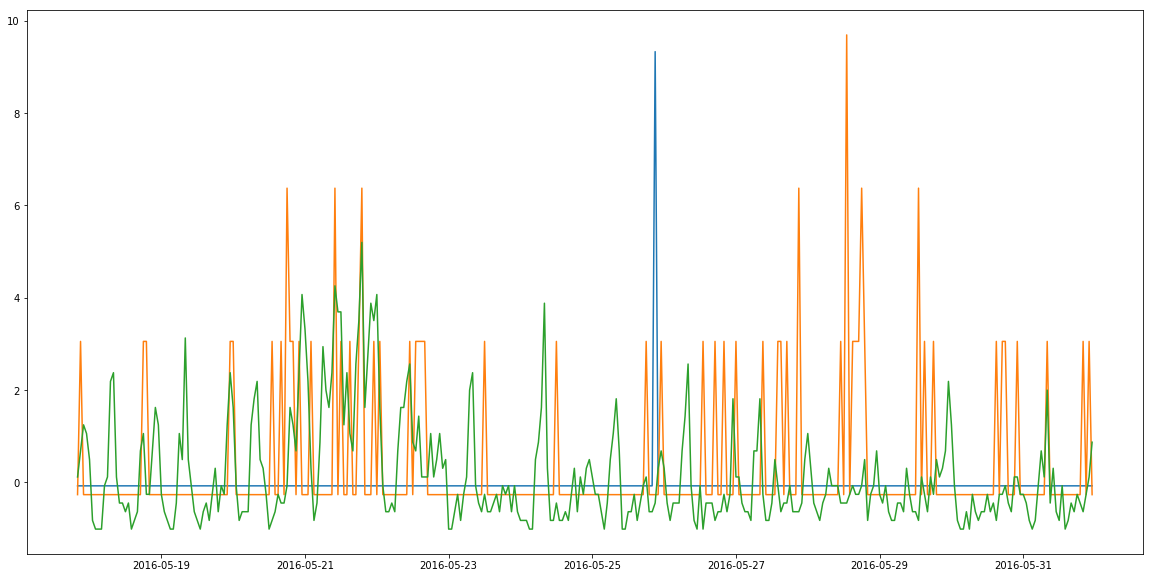

In [31]:
samples_to_visualize = 3

for n in range(n_clusters):
    plt.figure(figsize = (20, 10))
    regions = X.columns[np.where(n==kmeans.labels_)[0]][:samples_to_visualize]
    plt.plot(significant[regions].tail(340))

# Получаются неплохие результаты: кластер 2, откуда катаются более-менее случайно и поездок вообще немного, кластер 1, где распределение чуть сильнее скошено к началу дня (там люди живут, например, вызывают такси до работы), кластер 0, где скошено к концу дня (там люди могут работать, вызывать такси до дома).

# Экспериментально было выяснено, что ближайшие к центру кластера ряды рискуют оказываются с маленьким количеством поездок (Это неплохо видно из самого первого графика в ноутбуке.) и, стало быть, с малым количеством информации, их не стоит брать в качестве типичных. Было принято решение попробовать УСРЕДНИТЬ ряды из каждого кластера для получения типичного, очевидных подводных камней не обнаружено.

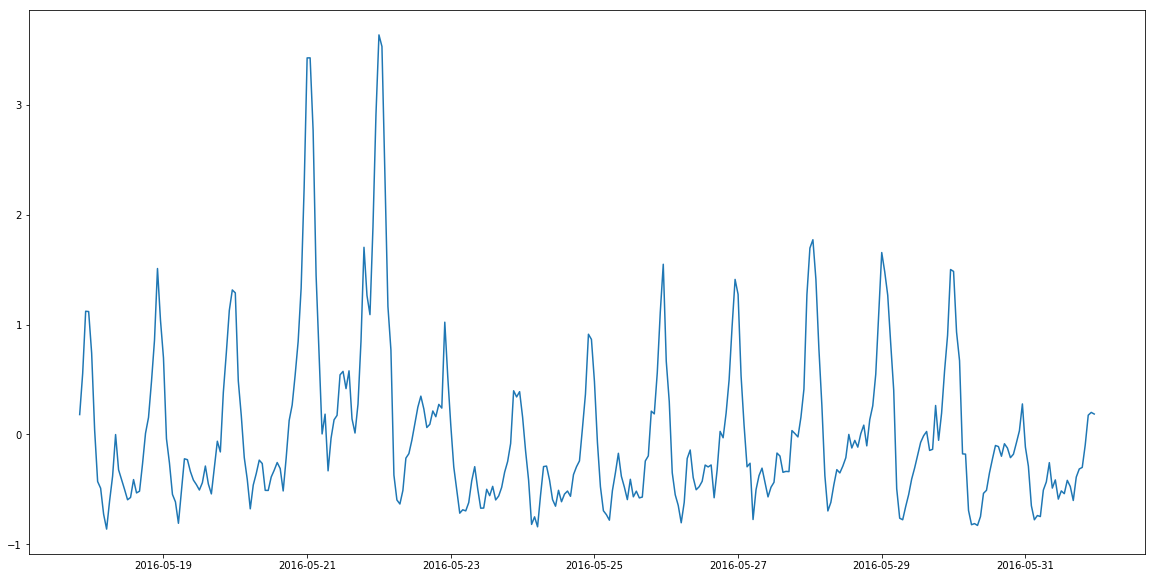

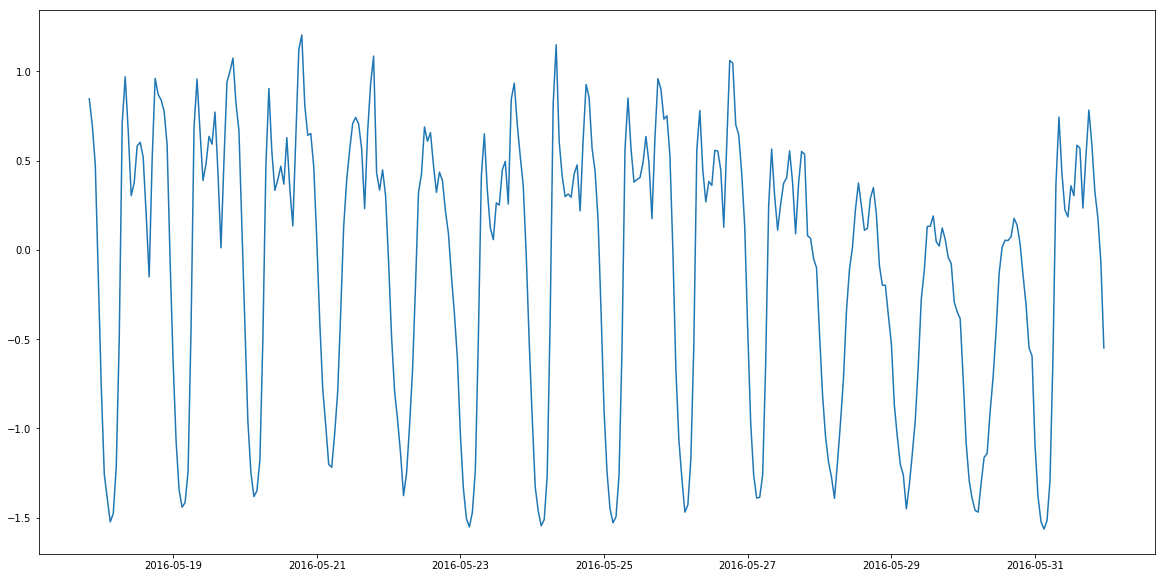

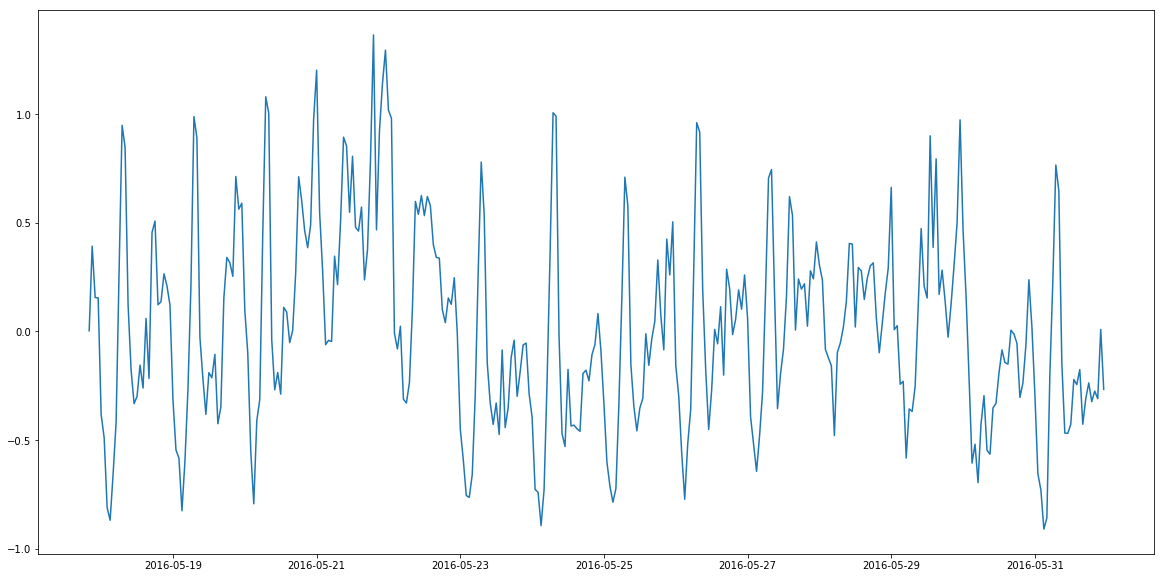

In [32]:
typical = pd.DataFrame()
for n in range(n_clusters):
    regions = X.columns[np.where(n==kmeans.labels_)[0]]
    typical[str(n)] = significant[regions].T.describe().T['mean']
    plt.figure(figsize = (20, 10))
    plt.plot(typical[typical.columns[-1]].tail(340))

In [33]:
typical.to_csv('typical.csv')
pd.Series(data = kmeans.labels_, index = significant.columns).to_csv('kmeans_labels.csv')

In [11]:
typical = pd.read_csv('typical.csv', index_col='Unnamed: 0')
typical.index = pd.to_datetime(typical.index)
typical.head()

,0,1,2
2016-02-01 00:00:00,-0.087794,-1.153534,-0.368889
2016-02-01 01:00:00,-0.261615,-1.391298,-0.520686
2016-02-01 02:00:00,-0.598785,-1.523086,-0.751718
2016-02-01 03:00:00,-0.734755,-1.566909,-0.933958
2016-02-01 04:00:00,-0.829587,-1.510855,-0.686956


## Повторяю сделанное на прошлой неделе.

## Сдвинутый Бокс-Кокс

In [12]:
def inverse_shifted_boxcox(y, lmda, shift=10):
    return np.exp(y) - shift if lmda == 0 else (np.exp(np.log(lmda * y + 1) / lmda)) - shift

def shifted_boxcox(y, shift=10):
    return stats.boxcox(y + shift)   

## Будем моделировать суточную сезонность с помощью SARIMAX, предварительно сделав регрессионные признаки для учёта недельной сезонности. Количество синосов и косинусов вычислялось путём взгляда на графики ACF и PACF после регрессии на признаки и выбора порядка дифференцирования

In [13]:
lmdas = []
cluster_names = typical.columns
for c in cluster_names:
    lmdas.append(0)
    typical[c+'_boxcox'], lmdas[-1] = shifted_boxcox(typical[c], shift = 3.)

K=75
p = 2.*pi/168.
for i in range(1, K+1):
    phi = p*i
    typical['week_s'+str(i)] = sin(np.array(list(range(0, len(typical))))*phi)
    typical['week_c'+str(i)] = cos(np.array(list(range(0, len(typical))))*phi)

typical = pd.concat([typical, pd.get_dummies(pd.Series(data = typical.index, index = typical.index).apply(lambda x: x.weekday()), drop_first=True)], axis=1)

X = typical.iloc[:, (2*n_clusters):]
y = typical.iloc[:, n_clusters:(2*n_clusters)]
typical.head()

,0,1,2,0_boxcox,1_boxcox,2_boxcox,week_s1,week_c1,week_s2,week_c2,...,week_s74,week_c74,week_s75,week_c75,1,2,3,4,5,6
2016-02-01 00:00:00,-0.087794,-1.153534,-0.368889,0.383124,1.218038,0.768481,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0,0,0,0,0,0
2016-02-01 01:00:00,-0.261615,-1.391298,-0.520686,0.378088,0.800510,0.731146,0.037391,0.999301,0.074730,0.997204,...,0.365341,-0.930874,0.330279,-0.943883,0,0,0,0,0,0
2016-02-01 02:00:00,-0.598785,-1.523086,-0.751718,0.364474,0.594535,0.667244,0.074730,0.997204,0.149042,0.988831,...,-0.680173,0.733052,-0.623490,0.781831,0,0,0,0,0,0
2016-02-01 03:00:00,-0.734755,-1.566909,-0.933958,0.356907,0.530054,0.609469,0.111964,0.993712,0.222521,0.974928,...,0.900969,-0.433884,0.846724,-0.532032,0,0,0,0,0,0
2016-02-01 04:00:00,-0.829587,-1.510855,-0.686956,0.350639,0.612888,0.686116,0.149042,0.988831,0.294755,0.955573,...,-0.997204,0.074730,-0.974928,0.222521,0,0,0,0,0,0


## Предскажем линейной регрессией

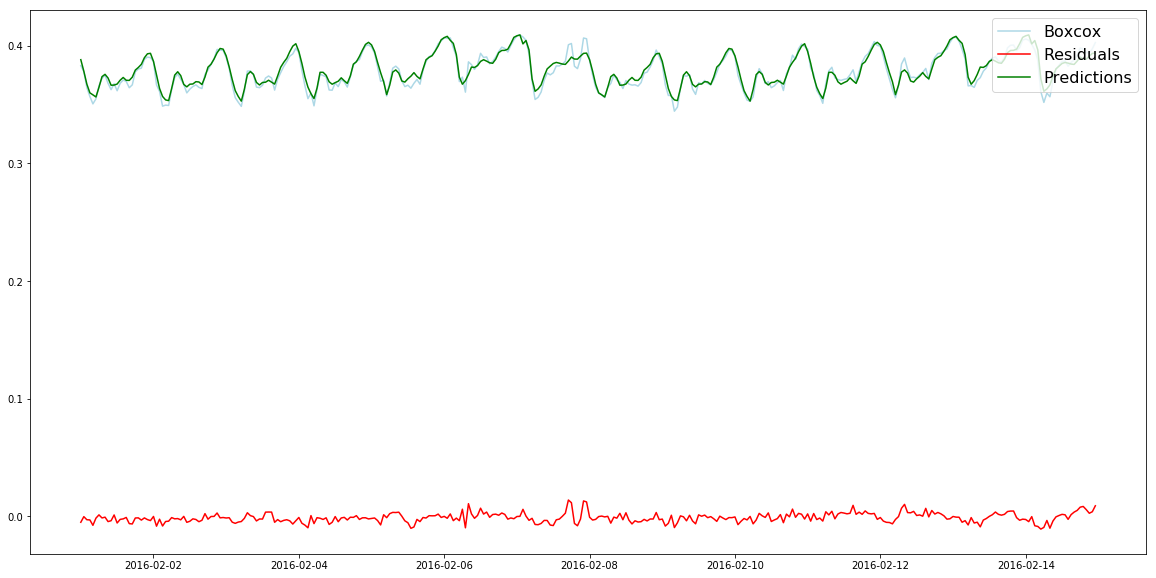

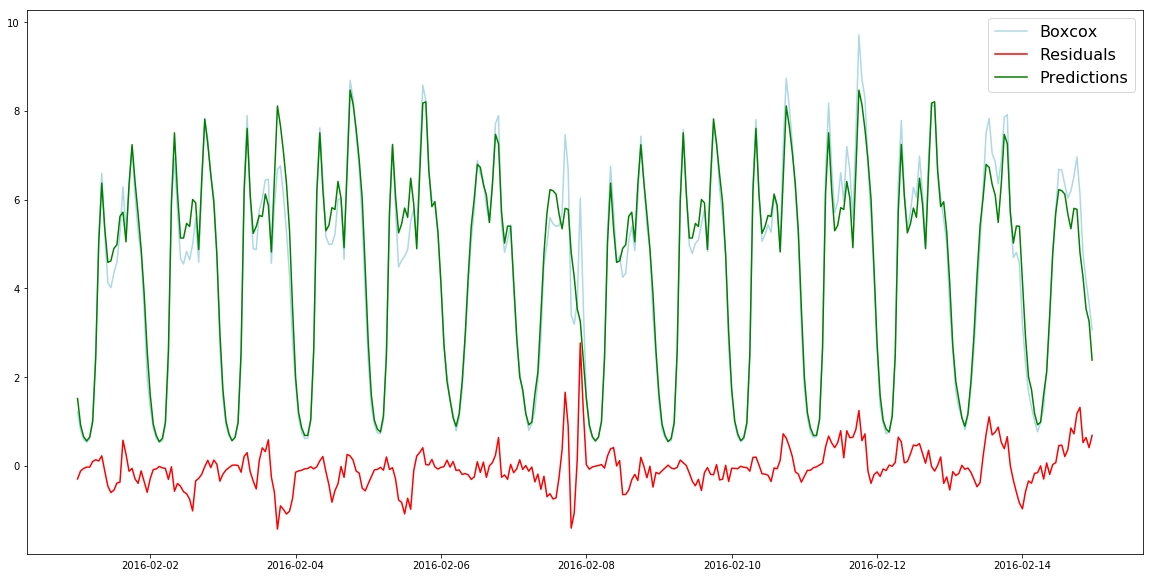

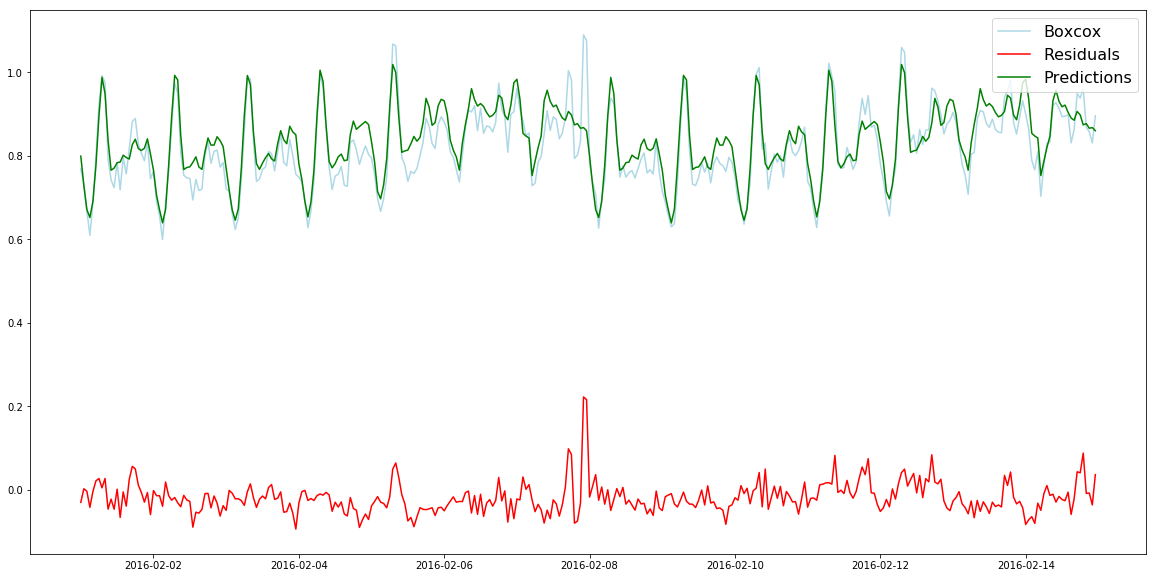

In [14]:
lr = LR()
lr.fit(X, y)
for i, pred in enumerate(lr.predict(X).transpose()):
    typical[cluster_names[i]+'_pred'] = pred
    typical[cluster_names[i]+'_resid'] = typical[cluster_names[i]+'_boxcox'] - typical[cluster_names[i]+'_pred']
    plt.figure(figsize=(20,10))
    plt.plot(typical[cluster_names[i]+'_boxcox'][:168*2], color ='lightblue', label='Boxcox')
    plt.plot(typical[cluster_names[i]+'_resid'][:168*2], label='Residuals', color='red')
    plt.plot(typical[cluster_names[i]+'_pred'][:168*2], label='Predictions', color='green')
    plt.legend(loc=1,prop={'size':16})

## Из-за вычислительной сложности, как и на прошлой неделе, не буду подавать exog в SARIMAX, а буду работать без exog с остатками регрессии.

# Выбор порядка дифференцирования

## D=0, d=0

0.002606882153403954
0.284240099135929
0.023423396020619203


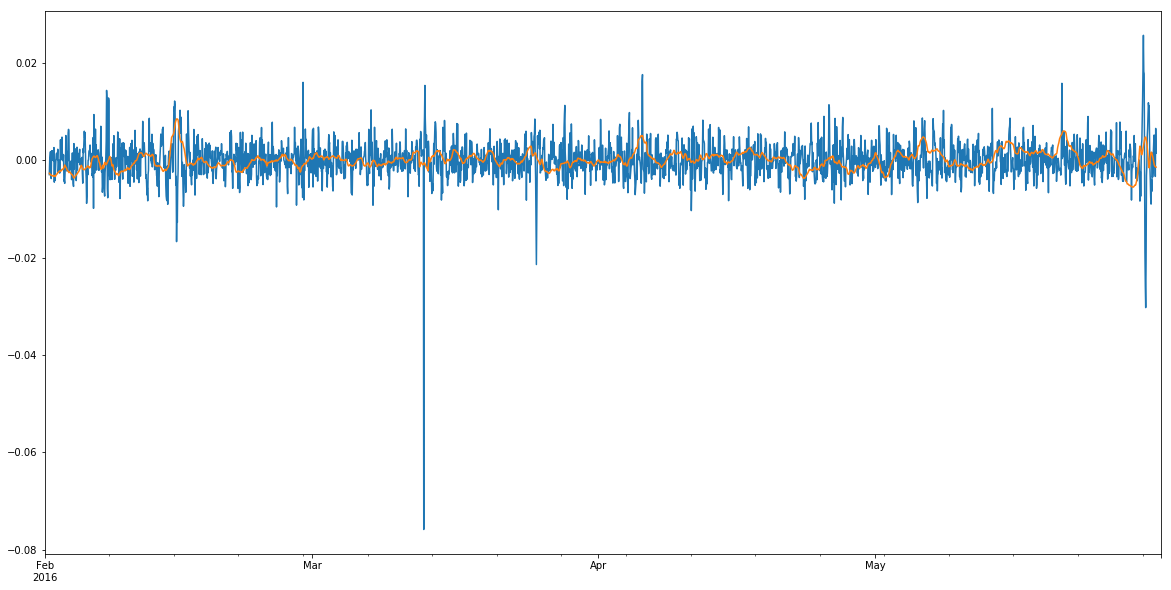

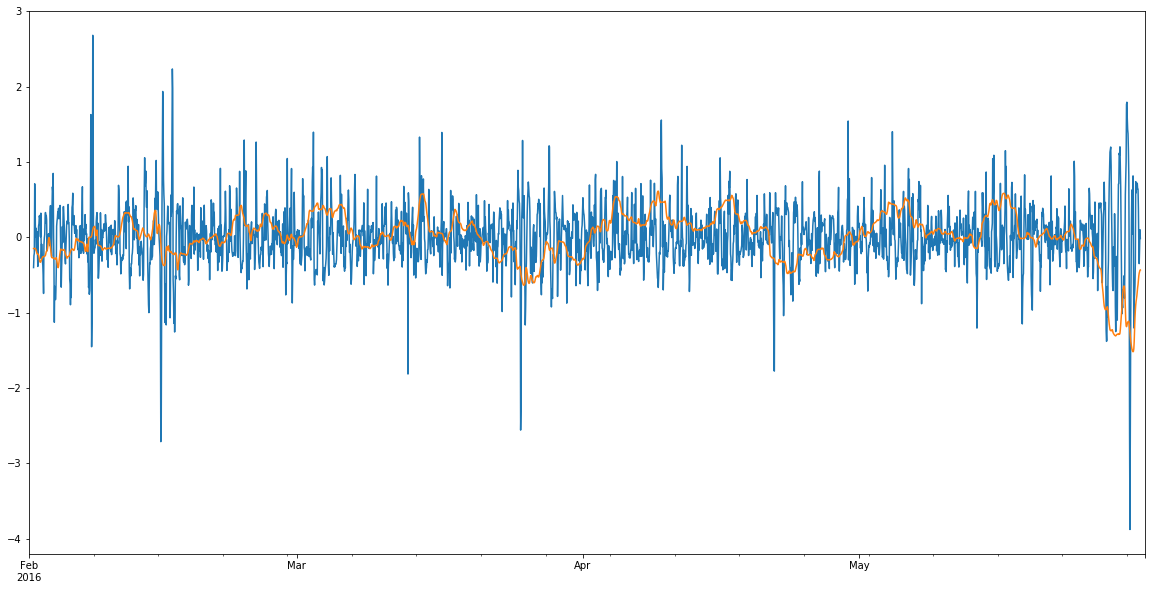

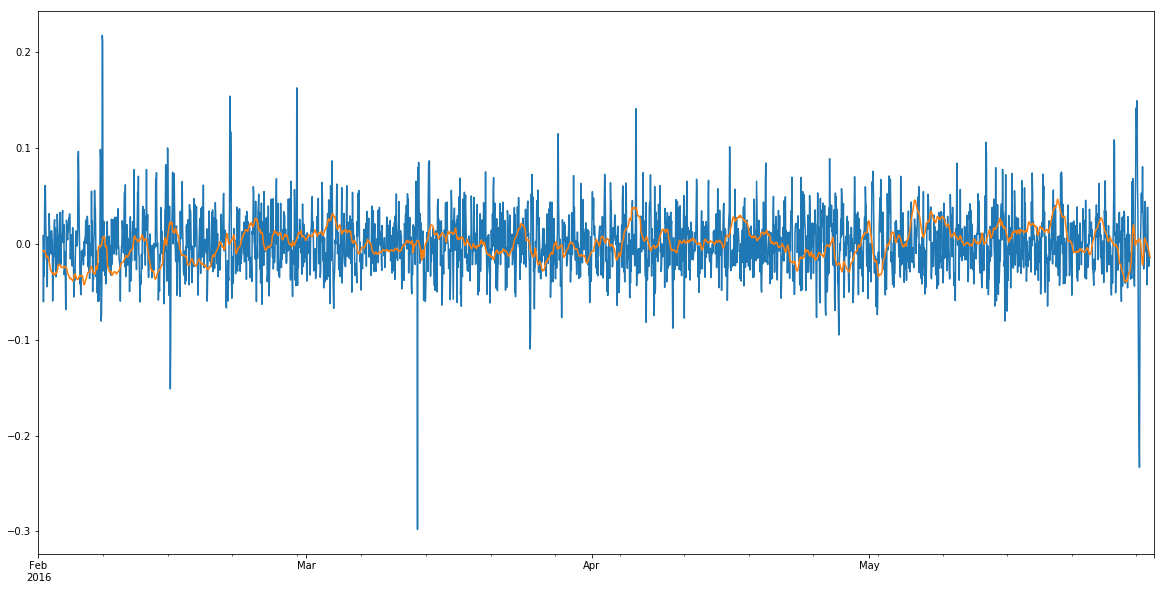

In [235]:
for i in cluster_names:
    plt.figure(figsize(20, 10))
    f = sm.tsa.seasonal_decompose(typical[i+'_resid'], freq=24)
    f.resid.plot()
    f.trend.plot()
    print(np.mean((f.resid ** 2)**0.5))

## D=0, d=1

0.002915429746919583
0.24037736074927113
0.02729266624747722


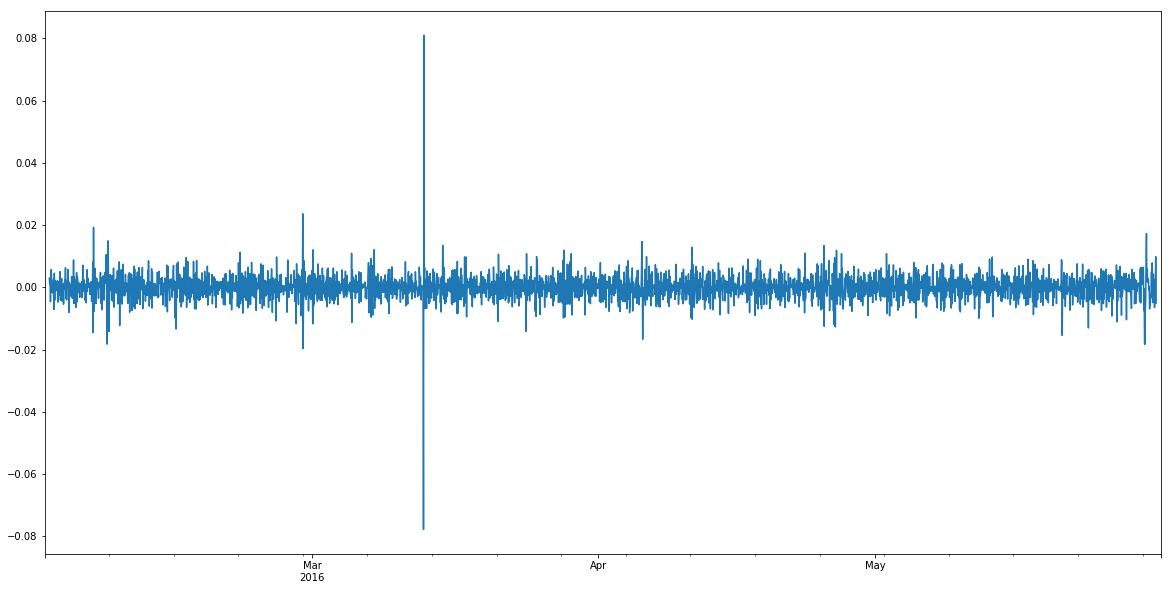

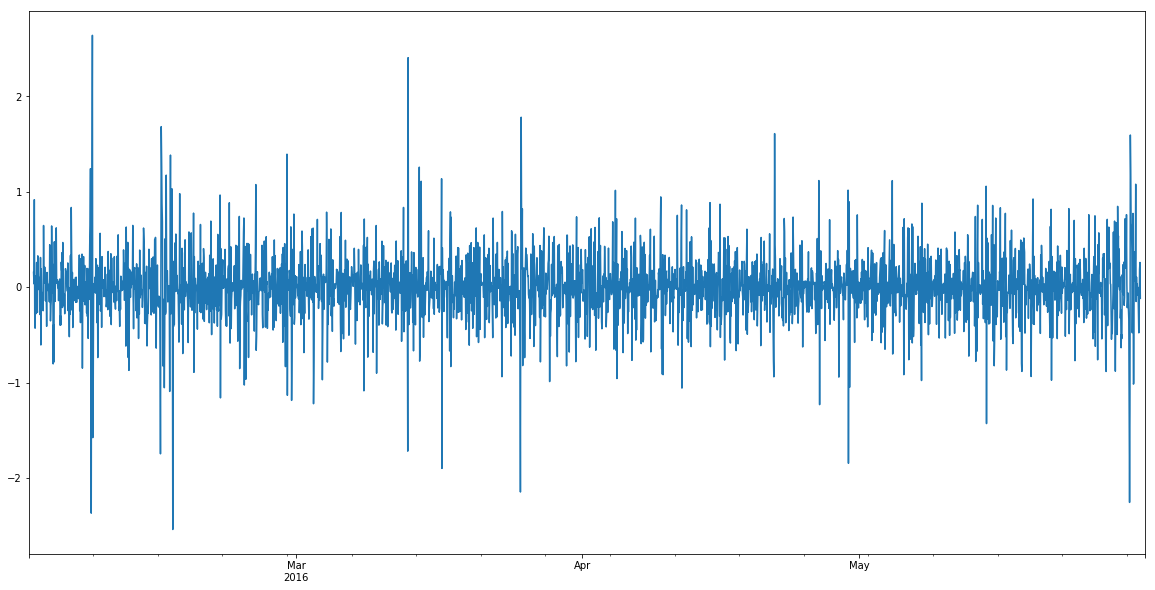

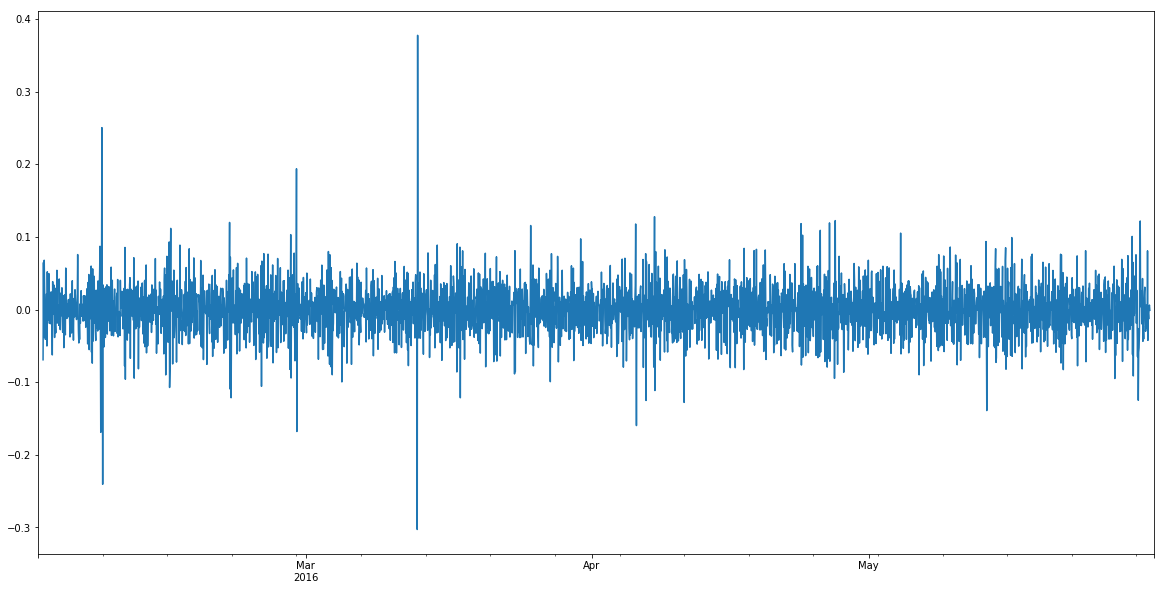

In [236]:
for i in cluster_names:
    plt.figure(figsize(20, 10))
    resid = typical[i+'_resid']
    resid = (resid - resid.shift(1))[1:]
    f = sm.tsa.seasonal_decompose(resid, freq=24)
    f.resid.plot(label='resid')
    print(np.mean((f.resid ** 2)**0.5))

## D=1, d=1

0.004111012226214088
0.31918195125440774
0.03834047252161175


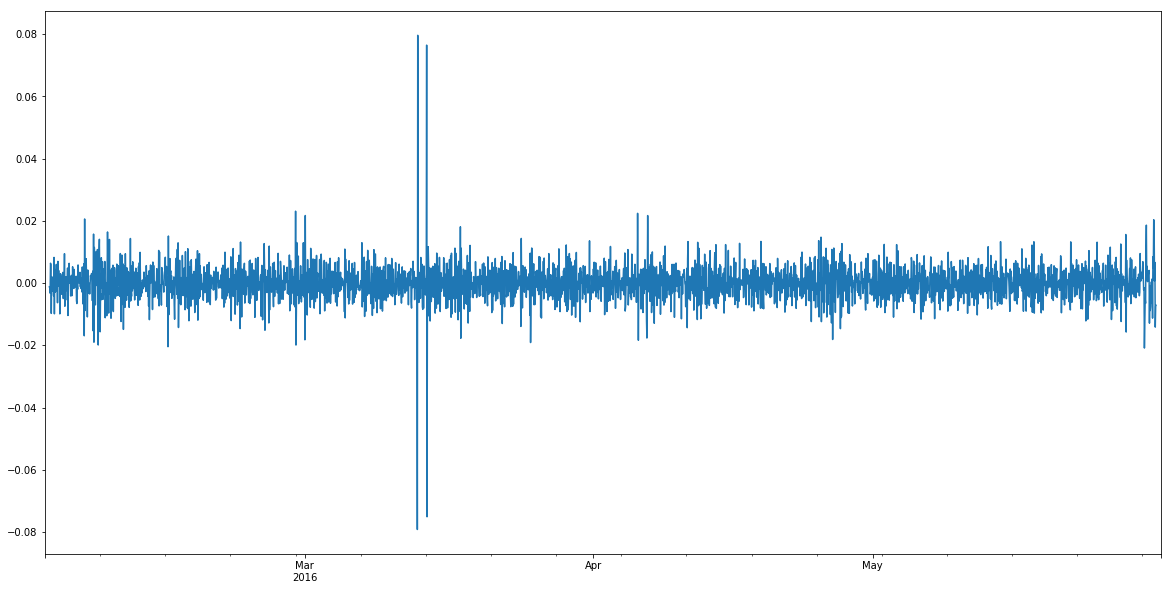

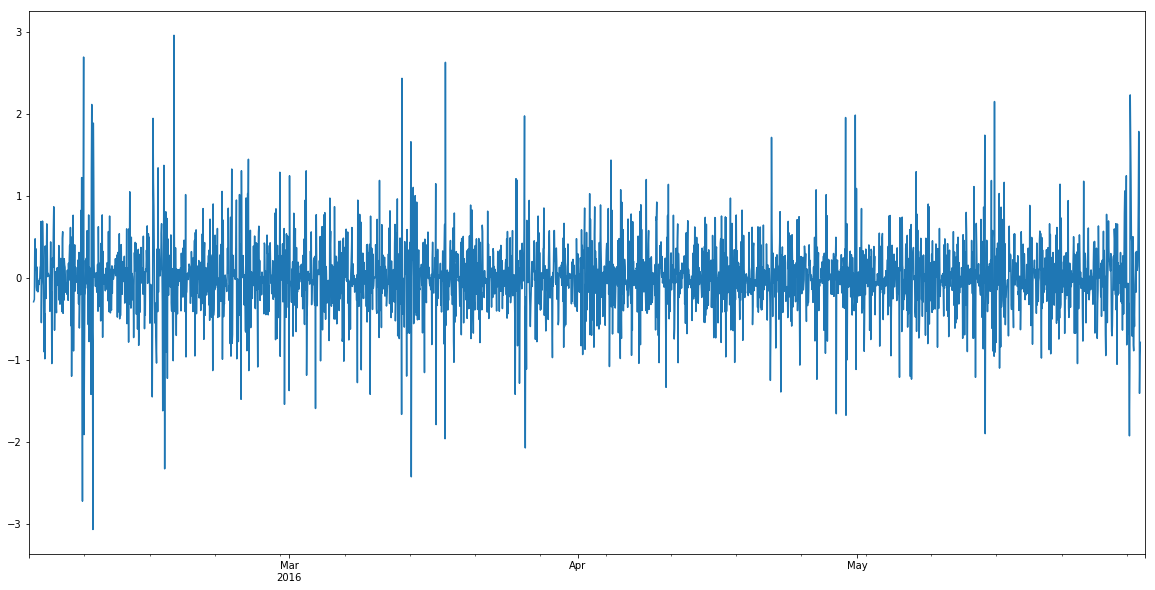

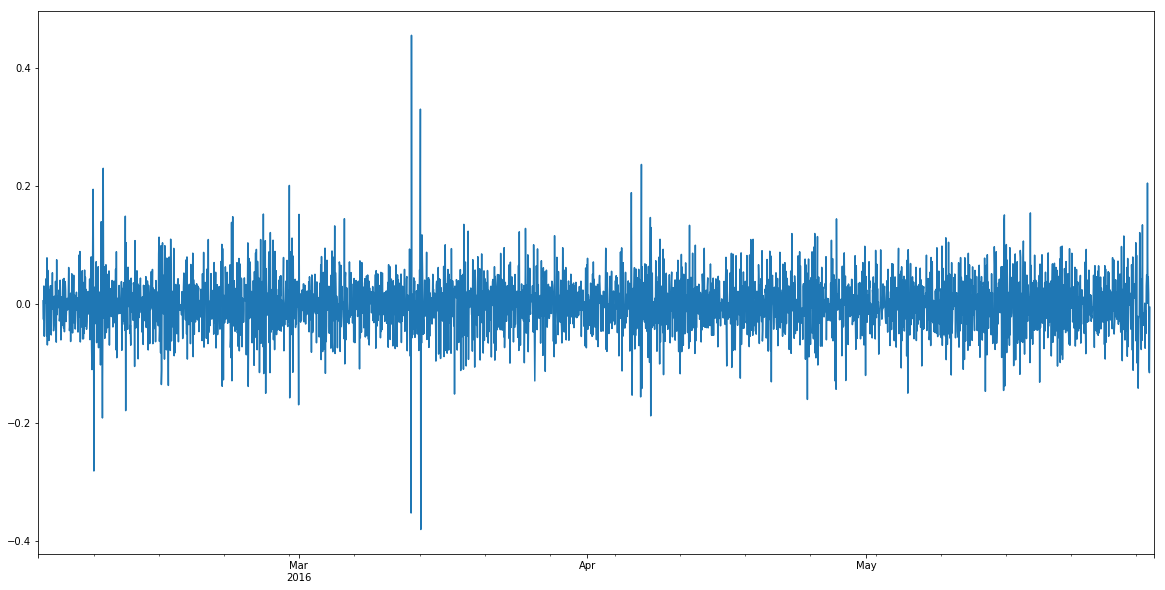

In [237]:
for i in cluster_names:
    plt.figure(figsize(20, 10))
    resid = typical[i+'_resid']
    resid = (resid - resid.shift(1))[1:]
    resid = (resid - resid.shift(24))[24:]
    f = sm.tsa.seasonal_decompose(resid, freq=24)
    f.resid.plot(label='resid')
    print(np.mean((f.resid ** 2)**0.5))

## D=1, d=0

0.003530191061598227
0.34422380081937404
0.03170394699402634


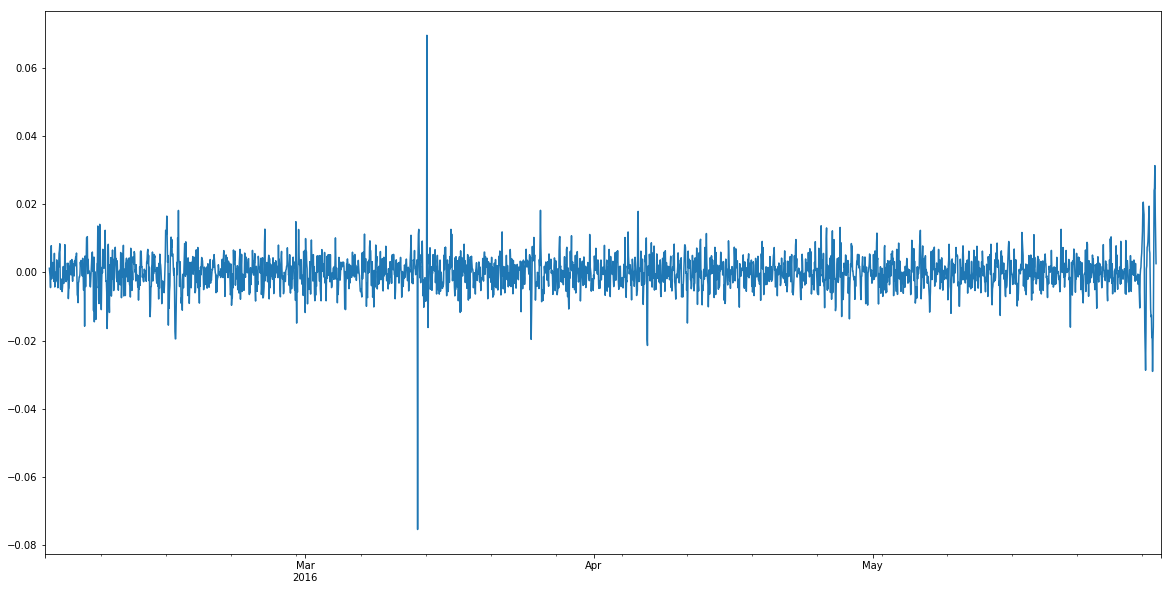

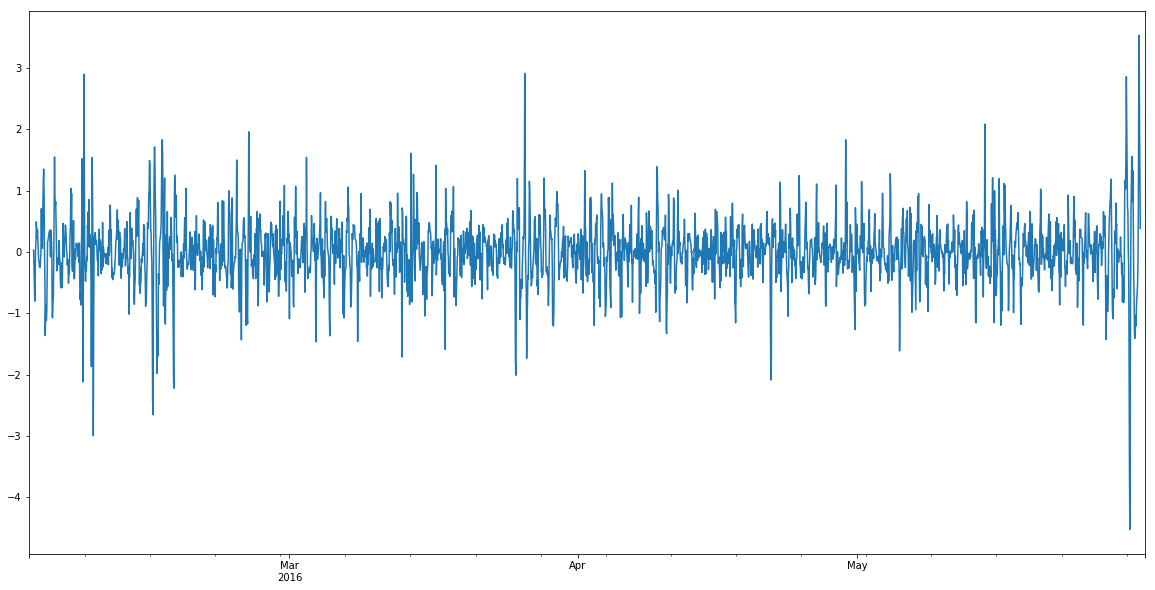

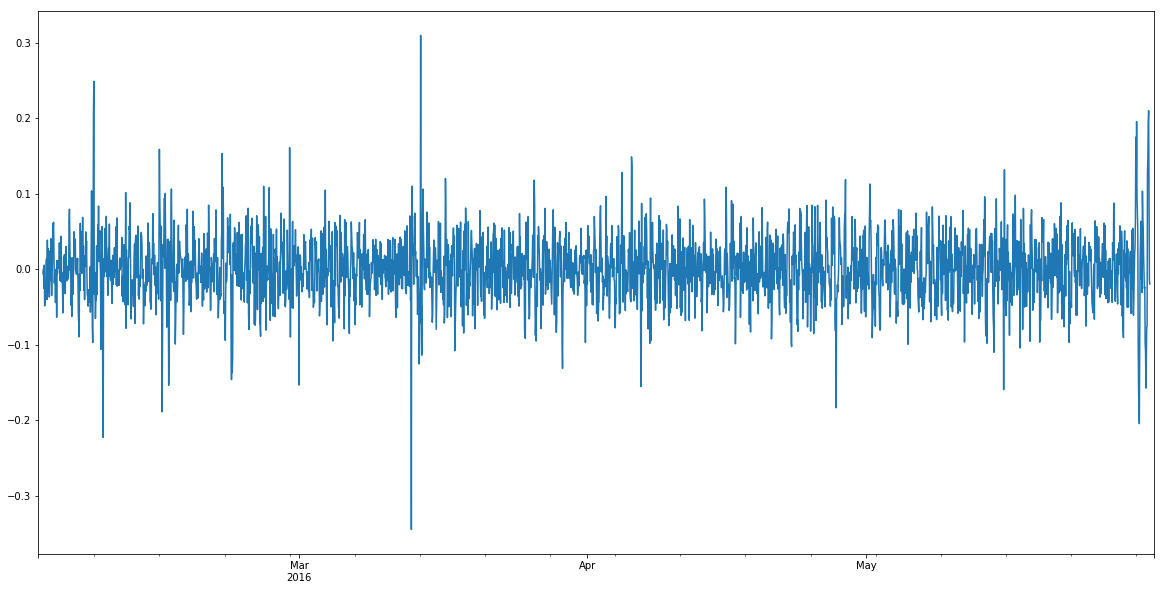

In [238]:
for i in cluster_names:
    plt.figure(figsize(20, 10))
    resid = typical[i+'_resid']
    resid = (resid - resid.shift(24))[24:]
    f = sm.tsa.seasonal_decompose(resid, freq=24)
    f.resid.plot(label='resid')
    print(np.mean((f.resid ** 2)**0.5))

## Из графиков выбираем для кластеров D, d

In [15]:
D_i = [0, 0, 0]
d_i = [0, 1, 0]

In [24]:
y = np.array(typical.iloc[:, [-5, -3, -1]])
y[:, 1] = np.array([[0]] + (np.array(y)[1:, [1]] - np.array(y)[:-1, [1]]).tolist())[:, 0]
y = y.transpose()
y

array([[-5.08332507e-03, -2.97936288e-04, -2.92638025e-03, ...,
        -5.05487465e-03, -8.19768431e-03, -7.94442807e-03],
       [ 0.00000000e+00,  1.79605886e-01,  5.65150648e-02, ...,
         1.42031869e-01,  3.96070898e-01,  4.05698865e-01],
       [-3.05910277e-02,  2.07781689e-03, -3.92505080e-03, ...,
        -6.34917839e-02,  1.26425892e-02, -3.02016485e-02]])

# Будем строить ACF и PACF для подбора p, P, q, Q

In [240]:
def plot_acf_pacf(data, lags):
    plt.figure(figsize(20,20))
    ax = plt.subplot(211)
    plt1 = sm.graphics.tsa.plot_acf(data.squeeze(), lags=lags, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    plt2 = sm.graphics.tsa.plot_pacf(data.squeeze(), lags=lags, ax=ax)
    pylab.show()

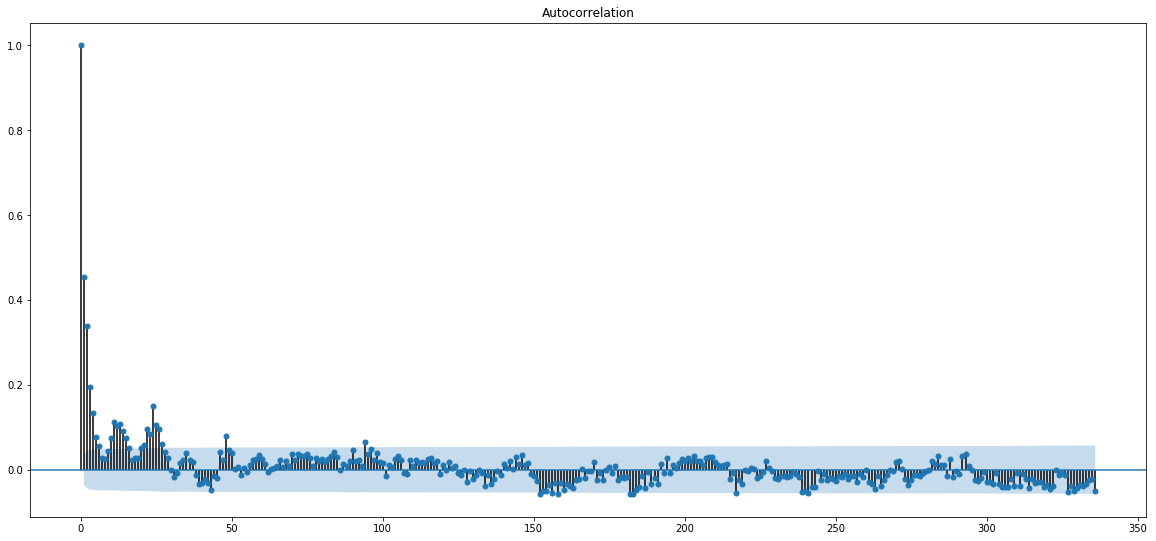

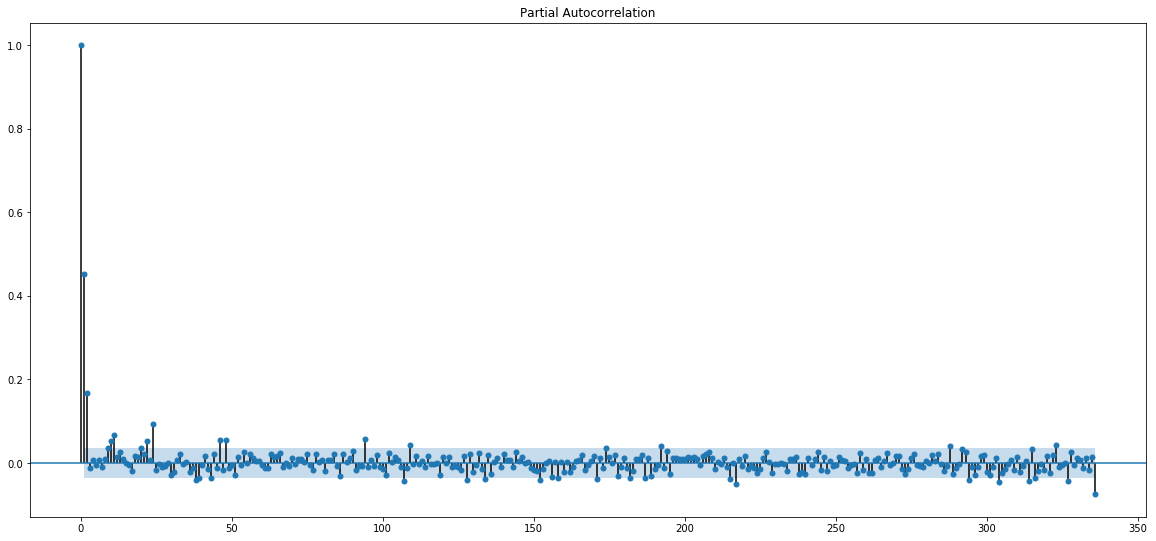

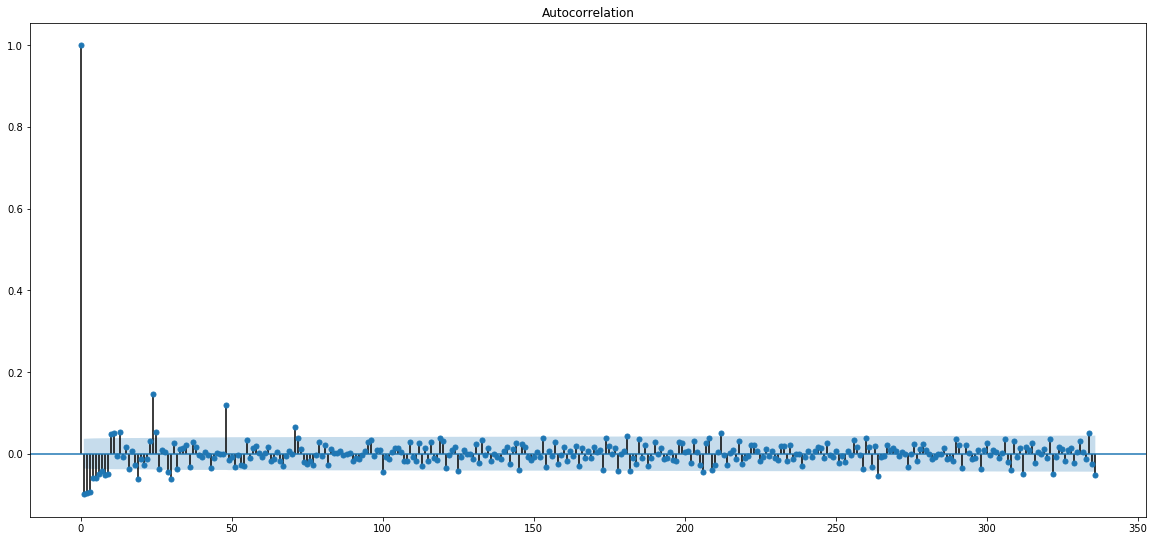

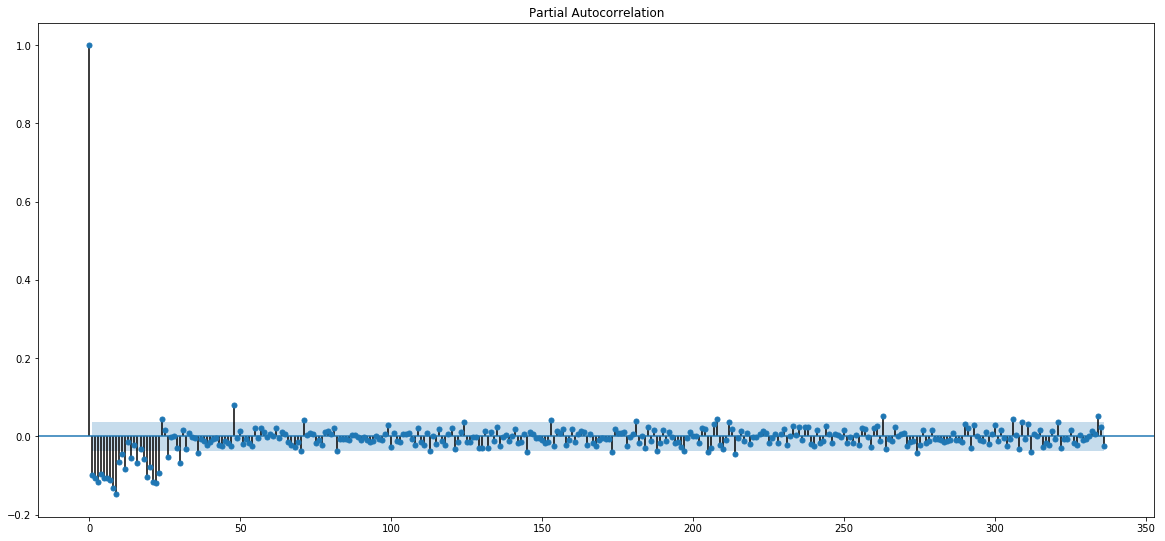

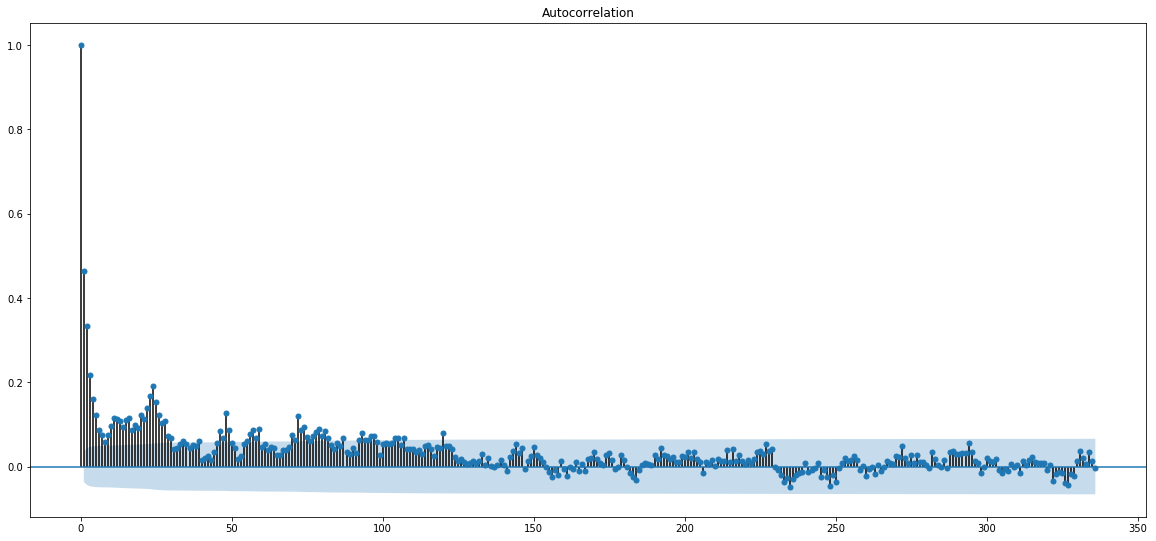

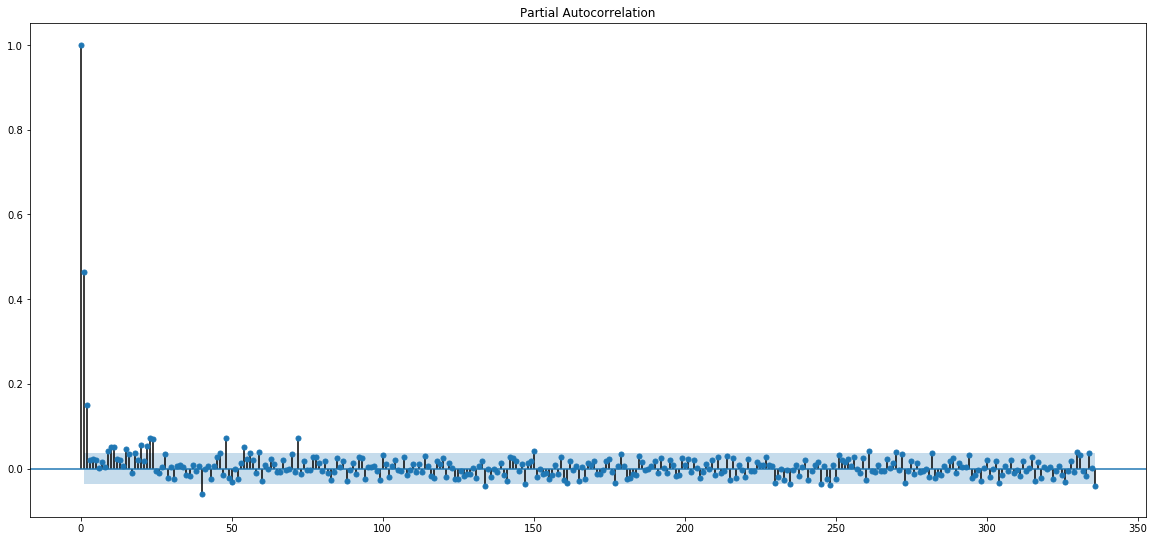

In [241]:
for series in y:
    plot_acf_pacf(series, 168*2)

## Используя графики, выберем коэффициенты для SARIMAX p, q, P, Q. Поскольку предсказывать будем на всех рядах каждого кластера по отдельности, критерий Акаике тут вообще может быть не самой удобной метрикой для выбора гиперпараметров, и все возможные множества гиперпараметров перебирать не буду. А ещё критерий Акаике не будет учитывать признаки, которые не были поданы как exog, количество которых сильно будет влиять на логарифм. Надо больше регрессионных признаков, для которых мы не будем считать ошибку регрессии, из соображений вычислительной сложности, и меньше, для которых будем.

In [16]:
p_i = [23, 23, 23]
q_i = [2, 3, 2]
P_i = [2, 3, 4]
Q_i = [2, 2, 3]

In [19]:
y = typical.iloc[:, [-5, -3, -1]]
y.to_csv('y.csv')

In [17]:
y = pd.read_csv('y.csv', index_col='Unnamed: 0')
y.index = pd.to_datetime(y.index)
y.head() # Типичный стандартизированный ряд

,0_resid,1_resid,2_resid
2016-02-01 00:00:00,-0.005083,-0.297387,-0.030591
2016-02-01 01:00:00,-0.000298,-0.117781,0.002078
2016-02-01 02:00:00,-0.002926,-0.061266,-0.003925
2016-02-01 03:00:00,-0.003088,-0.030587,-0.042545
2016-02-01 04:00:00,-0.007670,-0.030567,-0.004518


In [70]:
i = 0

p=p_i[i]
d=d_i[i]
q=q_i[i]
P=P_i[i]
D=D_i[i]
Q=Q_i[i]

ps = range(p, p+1)
qs = range(0, q+1)
Ps = range(P, P+1)
Qs = range(0, Q+1)

parameters_list = list(itertools.product(ps, qs, Ps, Qs))
print("Количество комбинаций параметров: %d" % len(parameters_list))

Количество комбинаций параметров: 9


In [7]:
i = 1

p=p_i[i]
d=d_i[i]
q=q_i[i]
P=P_i[i]
D=D_i[i]
Q=Q_i[i]

ps = range(p, p+1)
qs = range(0, q+1)
Ps = range(P, P+1)
Qs = range(0, Q+1)

parameters_list = list(itertools.product(ps, qs, Ps, Qs))
print("Количество комбинаций параметров: %d" % len(parameters_list))

Количество комбинаций параметров: 12


In [11]:
i = 2

p=p_i[i]
d=d_i[i]
q=q_i[i]
P=P_i[i]
D=D_i[i]
Q=Q_i[i]

ps = range(p, p+1)
qs = range(0, q+1)
Ps = range(P, P+1)
Qs = range(0, Q+1)

parameters_list = list(itertools.product(ps, qs, Ps, Qs))
print("Количество комбинаций параметров: %d" % len(parameters_list))

Количество комбинаций параметров: 12


# Подбор и сохранение лучших моделей для каждого из кластеров.

In [27]:
for i in range(n_clusters):
    p=p_i[i]
    d=d_i[i]
    q=q_i[i]
    P=P_i[i]
    D=D_i[i]
    Q=Q_i[i]

    ps = range(p, p+1)
    qs = range(0, q+1)
    Ps = range(P, P+1)
    Qs = range(0, Q+1)

    parameters_list = list(itertools.product(ps, qs, Ps, Qs))
    best_aic = float("inf")
    warnings.filterwarnings('ignore')

    for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model = sm.tsa.statespace.SARIMAX(y['0_resid'], 
                                              order=(param[0], d, param[1]), 
                                              seasonal_order=(param[2], D, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            continue
        aic = model.aic
    #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
    
    warnings.filterwarnings('default')
    with open('BM_'+str(i)+'.pickle', 'wb') as f:
        pickle.dump((best_param, best_model.params), f) #Сохраняю лучшие параметры

# Преобразую данные, на которых не происходило обучение (май, июнь), к виду, с которым работает SARIMAX: стандартизация, преобразование Бокса-Кокса со сдвигом, остатки регрессии

In [22]:
labels = pd.read_csv('kmeans_labels.csv', header=-1, index_col=0, names = ['region', 'label'])

In [23]:
scaled_data = pd.DataFrame(data=scaler.transform(data[significant.columns]), columns=significant.columns,
             index=data.index) # Стандартизация
for i in range(3):
    for col in [labels[labels.label==i].index][0]:
        scaled_data[str(col)+'_boxcox'] = stats.boxcox(scaled_data[col]+3., lmbda=lmdas[i]) # Бокс-Кокс

lr = [LR(), LR(), LR()]
X = typical.iloc[:, (2*n_clusters):-(2*n_clusters)]
for i in range(n_clusters):
    lr[i].fit(X, typical.iloc[:, n_clusters+i])
X = pd.concat([X.iloc[:168, :]]*(scaled_data.shape[0]//168+1)).head(scaled_data.shape[0])
for i in range(n_clusters):
    for col in [labels[labels.label==i].index][0]:
        scaled_data[str(col)+'_pred'] = lr[i].predict(X)
for i in range(n_clusters):
    for col in [labels[labels.label==i].index][0]:
        scaled_data[str(col)+'_resid'] = scaled_data[str(col)+'_boxcox'] - scaled_data[str(col)+'_pred'] # Остатки регрессии

scaled_data.to_csv('scaled_data.csv')

## Повторил для всех данных с прежними параметрами стандартизацию, Бокса-Кокса, вычитание предсказаний регрессии

In [29]:
scaled_data = pd.DataFrame(data=scaler.transform(data[significant.columns]), columns=significant.columns,
             index=data.index) # Стандартизация
for i in range(3):
    for col in [labels[labels.label==i].index][0]:
        scaled_data[str(col)+'_boxcox'] = stats.boxcox(scaled_data[col]+3., lmbda=lmdas[i]) # Бокс-Кокс

lr = [LR(), LR(), LR()]
X = typical.iloc[:, (2*n_clusters):-(2*n_clusters)]
for i in range(n_clusters):
    lr[i].fit(X, typical.iloc[:, n_clusters+i])
X = pd.concat([X.iloc[:168, :]]*(scaled_data.shape[0]//168+1)).head(scaled_data.shape[0])
for i in range(n_clusters):
    for col in [labels[labels.label==i].index][0]:
        scaled_data[str(col)+'_pred'] = lr[i].predict(X)
for i in range(n_clusters):
    for col in [labels[labels.label==i].index][0]:
        scaled_data[str(col)+'_resid'] = scaled_data[str(col)+'_boxcox'] - scaled_data[str(col)+'_pred'] # Остатки регрессии

scaled_data.to_csv('scaled_data.csv')

scaled_data.iloc[:5, range(97, 392, 98)]

,2167,2167_boxcox,2167_pred,2167_resid
2016-02-01 00:00:00,-0.063854,0.834575,0.799072,0.035503
2016-02-01 01:00:00,-0.063854,0.834575,0.729068,0.105507
2016-02-01 02:00:00,-0.063854,0.834575,0.671169,0.163406
2016-02-01 03:00:00,-0.063854,0.834575,0.652014,0.182561
2016-02-01 04:00:00,-0.063854,0.834575,0.690634,0.143941


In [24]:
scaled_data = pd.read_csv('scaled_data.csv', index_col='Unnamed: 0')
scaled_data.index = pd.to_datetime(scaled_data.index)

In [25]:
scaled_data.iloc[:5, range(97, 392, 98)]

,2167,2167_boxcox,2167_pred,2167_resid
2016-02-01 00:00:00,-0.063854,0.834575,0.799072,0.035503
2016-02-01 01:00:00,-0.063854,0.834575,0.729068,0.105507
2016-02-01 02:00:00,-0.063854,0.834575,0.671169,0.163406
2016-02-01 03:00:00,-0.063854,0.834575,0.652014,0.182561
2016-02-01 04:00:00,-0.063854,0.834575,0.690634,0.143941


# Предсказания SARIMAX:

In [30]:
first_history_end = pd.to_datetime('2016-05-31 23:00:00')
last_history_end = pd.to_datetime('2016-06-30 17:00:00')
first_forecast_beg = pd.to_datetime('2016-06-01 00:00:00')
last_forecast_beg = pd.to_datetime('2016-06-30 18:00:00')
first_forecast_end = pd.to_datetime('2016-06-01 05:00:00')
last_forecast_end = pd.to_datetime('2016-06-30 23:00:00')

histends = scaled_data.index[(first_history_end<=scaled_data.index) & (scaled_data.index<=last_history_end)]
forbegs = scaled_data.index[(first_forecast_beg<=scaled_data.index) & (scaled_data.index<=last_forecast_beg)]
forends = scaled_data.index[(first_forecast_end<=scaled_data.index) & (scaled_data.index<=last_forecast_end)]

dct = {}

In [48]:
for i in range(n_clusters): # Для каждого кластера
    d = d_i[i]
    D = D_i[i]
    with open('BM_'+str(i)+'.pickle', 'rb') as f: # Гружу модель для этого кластера
        param, params = pickle.load(f)
    lab = [labels[labels.label==i].index][0]
    l = len(lab)
    for x, col in enumerate(lab): # Для всех принадлежащих кластерам регионов
        model_ = sm.tsa.statespace.SARIMAX(scaled_data[str(col)+'_resid'].tail(1500), 
                                           order=(param[0], d, param[1]), 
                                           seasonal_order=(param[2], D, param[3], 24)).filter(params)
        dct = {}
        for t, histend in enumerate(histends):
            forbeg = forbegs[t]
            forend = forends[t]
            str_he = str(histend)
            str_he = str(col)+'_'+str_he[:10]+'_'+str_he[11:]+'_'
            sarimaxpred = model_.predict(start=forbeg, end = forend, dynamic=True, params=params) # Строю предсказания SARIMAX
            boxcox = scaled_data[str(col)+'_pred']+sarimaxpred # Складываю с предсказаниями регрессии для этого кластера
            boxcox = boxcox[boxcox==boxcox]
            scaled_pred = inverse_shifted_boxcox(boxcox, lmda=lmdas[i], shift=3.) # Обратный сдвинутый Бокс-Кокс
            dct[str_he] = scaled_pred
        with open('significant_regions/'+str(col)+'.pickle', 'wb') as f:
            pickle.dump(dct, f)

### Колдовство, нужное, чтобы сразу над всеми регионами провести обратную стандартизацию

In [3]:
data = pd.read_csv('data.csv', index_col='Unnamed: 0')
data.index = pd.to_datetime(data.index)
test_datetimes_cnt = 720
train = data.head(data.shape[0]-test_datetimes_cnt)
test = data.tail(test_datetimes_cnt)
threshold = 5.
avg = train.describe().T['mean']
significant = train[[str(x) for x in list(np.where(avg > threshold))[0]]]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
significant = pd.DataFrame(index = train.index, columns = significant.columns, data = scaler.fit_transform(significant))

n_clusters = 3
labels = pd.read_csv('kmeans_labels.csv', header=-1, index_col=0, names = ['region', 'label'])
scaled_data = pd.read_csv('scaled_data.csv', index_col='Unnamed: 0')
scaled_data.index = pd.to_datetime(scaled_data.index)

In [4]:
d = {}
scaled_d = {}
for region in labels.index:
    with open('significant_regions/'+str(region)+'.pickle', 'rb') as f:
        dct = pickle.load(f)
    for x in dct.keys():
        for i, ind in enumerate(dct[x].index):
            scaled_d[x+str(i+1)] = scaled_data[x[:4]][ind]
            d[x+str(i+1)] = dct[x][ind]

df = pd.DataFrame(index=d.keys())
df['scaled_pred'] = pd.Series(df.index).apply(lambda x: d[x]).values
df['scaled'] = pd.Series(df.index).apply(lambda x: scaled_d[x]).values
df['r'] = pd.Series(df.index).apply(lambda x: int(x[:4])).values
df.index = pd.Series(df.index).apply(lambda x: x[4:]).values

scaled_pred = pd.DataFrame(index = df.index.value_counts().index)
scaled = pd.DataFrame(index = df.index.value_counts().index)
for region in significant.columns:
    region = int(region)
    scaled_pred[region] = df['scaled_pred'][df.r == region].values
    scaled[region] = df['scaled'][df.r == region].values

## Обратная стандартизация

In [8]:
sarimax_pred = pd.DataFrame(index = scaled_pred.index, columns=significant.columns,
                            data = scaler.inverse_transform(scaled_pred))
true_values = pd.DataFrame(index = scaled.index, columns=significant.columns,
                            data = scaler.inverse_transform(scaled))

In [9]:
true_values.describe()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1579,1683,1732,1733,1782,2067,2068,2117,2118,2167
count,4.290000e+03,4290.000000,4290.000000,4.290000e+03,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,...,4.290000e+03,4.290000e+03,4.290000e+03,4.290000e+03,4.290000e+03,4.290000e+03,4.290000e+03,4.290000e+03,4290.000000,4.290000e+03
mean,5.594406e-03,72.110023,139.590443,1.480186e-01,67.589977,186.738462,257.656410,281.930769,323.440093,407.455245,...,1.594406e-01,4.330070e+00,1.074825e+00,5.625874e+00,6.111888e-01,1.608392e-02,9.408531e+01,1.398601e-02,143.023543,2.797203e-03
std,7.459494e-02,45.300417,79.461201,3.925775e-01,36.077673,95.063141,124.713281,153.473874,175.572849,234.208848,...,4.485522e-01,4.074860e+00,1.321926e+00,3.925113e+00,9.022475e-01,1.258130e-01,5.785667e+01,1.174462e-01,74.351187,5.282072e-02
min,-1.439820e-16,1.000000,2.000000,-1.249001e-15,1.000000,11.000000,15.000000,29.000000,49.000000,42.000000,...,-3.608225e-15,-1.021405e-14,1.154632e-14,7.460699e-14,1.132427e-14,-6.158268e-17,-7.105427e-14,4.787837e-16,1.000000,2.012279e-16
25%,-1.439820e-16,29.000000,63.000000,-1.249001e-15,39.000000,115.000000,171.000000,183.000000,213.000000,264.000000,...,-3.608225e-15,1.000000e+00,1.154632e-14,2.000000e+00,1.132427e-14,-6.158268e-17,4.800000e+01,4.787837e-16,80.000000,2.012279e-16
50%,-1.439820e-16,75.000000,163.000000,-1.249001e-15,72.000000,197.000000,272.000000,276.000000,293.000000,350.000000,...,-3.608225e-15,3.000000e+00,1.000000e+00,6.000000e+00,1.132427e-14,-6.158268e-17,9.400000e+01,4.787837e-16,152.000000,2.012279e-16
75%,-1.439820e-16,107.000000,201.000000,-1.249001e-15,95.000000,254.000000,341.000000,366.000000,417.000000,537.000000,...,-3.608225e-15,7.000000e+00,2.000000e+00,8.000000e+00,1.000000e+00,-6.158268e-17,1.400000e+02,4.787837e-16,203.000000,2.012279e-16
max,1.000000e+00,205.000000,320.000000,2.000000e+00,166.000000,414.000000,648.000000,680.000000,977.000000,1419.000000,...,5.000000e+00,2.000000e+01,7.000000e+00,1.900000e+01,6.000000e+00,1.000000e+00,2.600000e+02,1.000000e+00,326.000000,1.000000e+00


In [11]:
sarimax_pred.describe()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1579,1683,1732,1733,1782,2067,2068,2117,2118,2167
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,...,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,0.004328,75.419806,142.300830,0.089024,67.957770,189.365715,260.673454,270.466995,318.134472,392.056437,...,0.109033,4.614519,0.950417,5.852030,0.472759,0.006517,98.538295,0.009033,149.802613,0.004418
std,0.033935,34.306962,70.179094,0.126461,33.853707,84.290058,114.260790,132.671831,156.413454,216.991797,...,0.145128,3.374922,0.631848,3.379916,0.368845,0.030793,45.893534,0.040608,57.466422,0.041855
min,-0.073585,-10.122497,-18.095560,-0.168123,-42.283385,-85.253100,-109.909457,53.571202,86.455677,109.038913,...,-0.212828,-6.531066,-0.205289,-6.343618,-0.258792,-0.062483,-29.617739,-0.082118,-5.596350,-0.093462
25%,-0.018008,48.993146,80.136842,-0.003558,42.957674,125.751130,181.504638,191.391691,223.831083,264.560917,...,0.011811,1.911469,0.514096,3.417377,0.217448,-0.014192,65.501933,-0.017251,110.958753,-0.023256
50%,0.001200,84.284961,170.583659,0.080217,78.335910,215.972108,295.395001,235.419767,275.481812,323.740661,...,0.092071,5.305707,0.790986,6.733911,0.407620,0.003412,110.586561,0.004569,161.379834,0.000957
75%,0.022557,100.210543,196.524976,0.167450,92.493125,250.477574,341.512213,311.660789,360.168528,445.304127,...,0.186392,7.121483,1.242143,8.442268,0.663582,0.022443,133.085526,0.029907,192.590383,0.026245
max,0.260376,186.162184,297.640565,0.718713,144.102593,368.699257,534.254642,907.138482,1323.375468,1736.417985,...,0.921437,16.514342,4.753891,16.648535,2.952107,0.215043,210.567078,0.220331,300.654414,0.182473


# Сходство в принципе заметно, хотя некоторые предсказанные значения отрицательные. Их логично заменить нулями.

In [12]:
sarimax_pred[sarimax_pred<0] = 0
sarimax_pred.describe()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1579,1683,1732,1733,1782,2067,2068,2117,2118,2167
count,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,...,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000,4290.000000
mean,0.015285,75.436730,142.361092,0.103851,68.272971,189.577319,261.094800,270.466995,318.134472,392.056437,...,0.123477,4.756481,0.951168,5.923311,0.476667,0.015244,98.691901,0.020245,149.804197,0.018371
std,0.023454,34.268719,70.052868,0.109019,33.119594,83.768941,113.209389,132.671831,156.413454,216.991797,...,0.127564,3.123320,0.630655,3.227205,0.363117,0.022357,45.536422,0.029539,57.462228,0.028434
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,53.571202,86.455677,109.038913,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,48.993146,80.136842,0.000000,42.957674,125.751130,181.504638,191.391691,223.831083,264.560917,...,0.011811,1.911469,0.514096,3.417377,0.217448,0.000000,65.501933,0.000000,110.958753,0.000000
50%,0.001200,84.284961,170.583659,0.080217,78.335910,215.972108,295.395001,235.419767,275.481812,323.740661,...,0.092071,5.305707,0.790986,6.733911,0.407620,0.003412,110.586561,0.004569,161.379834,0.000957
75%,0.022557,100.210543,196.524976,0.167450,92.493125,250.477574,341.512213,311.660789,360.168528,445.304127,...,0.186392,7.121483,1.242143,8.442268,0.663582,0.022443,133.085526,0.029907,192.590383,0.026245
max,0.260376,186.162184,297.640565,0.718713,144.102593,368.699257,534.254642,907.138482,1323.375468,1736.417985,...,0.921437,16.514342,4.753891,16.648535,2.952107,0.215043,210.567078,0.220331,300.654414,0.182473


# Можно заметить, что функционал ошибки - это просто средняя абсолютная ошибка (MAE) ВСЕХ предсказываемых чисел:

In [13]:
Q_june = mean(mean(abs(sarimax_pred-true_values)))
Q_june

26.062881626891446

## Теперь добавлю оставшиеся ряды, для которых предсказание будет просто средним арифметическим.

In [24]:
for col in train.columns:
    if not (col in sarimax_pred.columns):
        sarimax_pred[col] = [mean(train[col])]*(6*715)

In [80]:
sarimax_pred.to_csv('sarimax_pred.csv')

## Берем с Kaggle интересующие нас регионы

In [16]:
kaggle_regions = pd.Series(pd.read_csv('sample_solution.csv',\
                                       index_col='id').index).apply(lambda x:x[:4]).value_counts().index

### Перевод в форму сабмишшена для Kaggle

In [17]:
sarimax_pred = pd.read_csv('sarimax_pred.csv', index_col='Unnamed: 0')

In [27]:
ind = pd.Series(sarimax_pred.index, name='id').apply(lambda x: x[:12]+str(int(x[12:14]))+x[-2:])
my_sub = pd.DataFrame()
for col in kaggle_regions:
    sub_tmp = pd.DataFrame(index = col+ind, data = sarimax_pred[col].values, columns=['y'])
    my_sub = pd.concat([my_sub, sub_tmp])
my_sub.to_csv('my_sub.csv')
my_sub.head()

,y
id,
1286_2016-06-28_1_2,18.169767
1286_2016-06-16_9_3,0.000000
1286_2016-06-08_16_6,0.000000
1286_2016-06-20_8_5,0.000000
1286_2016-06-30_4_5,0.000000


# Ссылка на сабмишн: https://www.kaggle.com/submissions/7355184